<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 486 (delta 135), reused 62 (delta 60), pack-reused 302
Receiving objects: 100% (486/486), 12.92 MiB | 20.77 MiB/s, done.
Resolving deltas: 100% (288/288), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [3]:
SEED = 42 # fix random seed for reproducibility

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.26G/1.28G [00:13<00:00, 97.6MB/s]
100% 1.28G/1.28G [00:13<00:00, 99.1MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary infomation

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## 1.3 Balance the dataset

In [61]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


Set a minimum and maximum threshold for category counts. N.B.: we are referring to category list counts and not single category counts!

In [62]:
num_min = 300
num_max = 400

utils.categories_as_strings(df) # take "category" as a column of strings

# Drop the lists of categories that have less than num_min counts.
cut_num_min = lambda x : len(x) > num_min
df = df.groupby('category').filter(cut_num_min)

# Sample num_max times those categories that have more than num_max counts.
sample_num_max = lambda x: x.sample(min(len(x), num_max))
df = df.groupby('category', as_index = False, group_keys=False)
df = df.apply(sample_num_max).reset_index(drop=True)

print(f"The dataset contains {len(df)} articles.")
df.head()

The dataset contains 63005 articles.


,id,title,category,abstract
0,2401.18072,GODMAX: Modeling gas thermodynamics and matter...,"['astro-ph.CO', 'astro-ph.GA']",We introduce GODMAX (Gas thermODynamics and ...
1,2212.05964,Baryonic Imprints on DM Halos: The concentrati...,"['astro-ph.CO', 'astro-ph.GA']","The physics of baryons in halos, and their s..."
2,2211.01744,The galaxy formation origin of the lensing is ...,"['astro-ph.CO', 'astro-ph.GA']",Recent analyses show that $\Lambda$CDM-based...
3,2312.04621,Detecting strongly-lensed type Ia supernovae w...,"['astro-ph.CO', 'astro-ph.GA']",Strongly-lensed supernovae are rare and valu...
4,2303.03058,Reoriented Memory of Galaxy Spins for the Earl...,"['astro-ph.CO', 'astro-ph.GA']",Galaxy spins are believed to retain the init...


Visualize the dataset distribution.

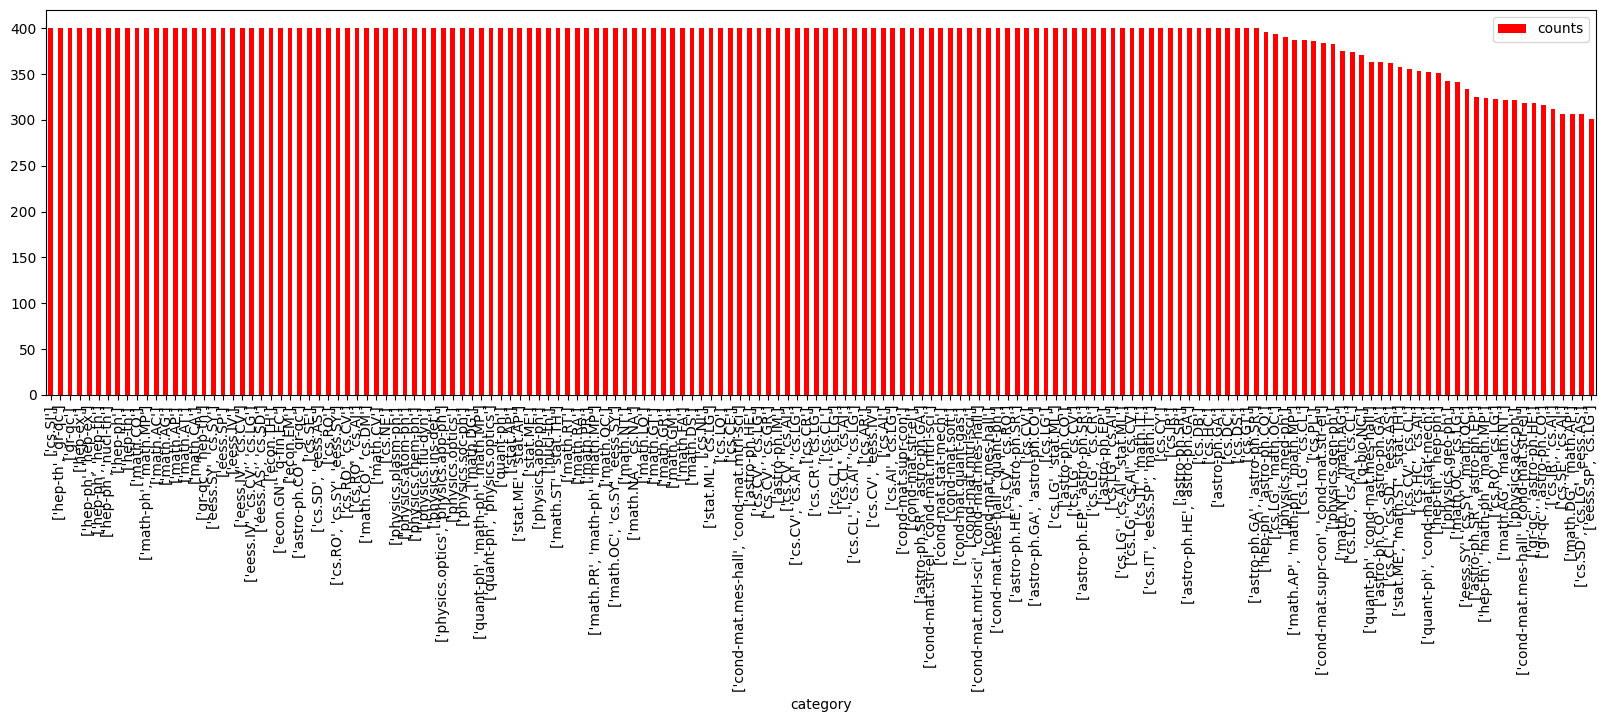

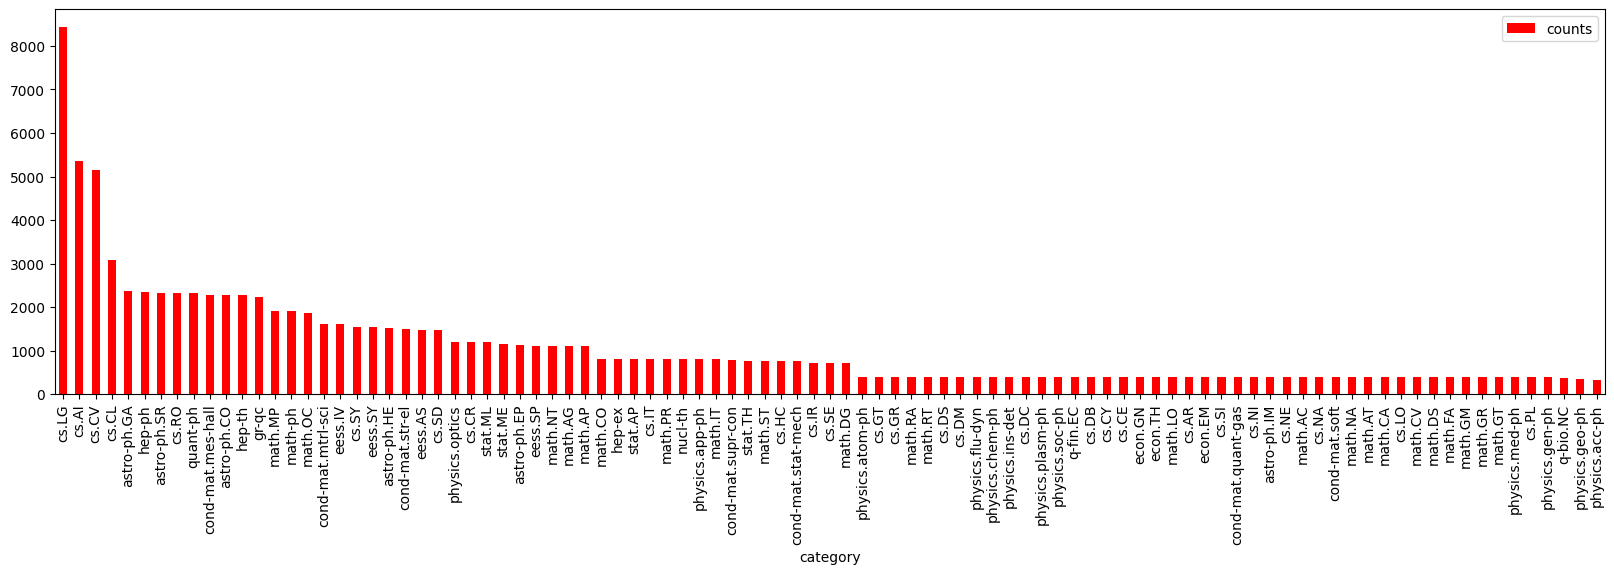

In [63]:
# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")


# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

In [64]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
df = df.loc[df['category'].explode().isin(sub_C).loc[lambda x: x].index]
df.head()

Number of categories appearing in the dataset: 95
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,2401.18072,GODMAX: Modeling gas thermodynamics and matter...,"[astro-ph.CO, astro-ph.GA]",We introduce GODMAX (Gas thermODynamics and ...
1,2212.05964,Baryonic Imprints on DM Halos: The concentrati...,"[astro-ph.CO, astro-ph.GA]","The physics of baryons in halos, and their s..."
2,2211.01744,The galaxy formation origin of the lensing is ...,"[astro-ph.CO, astro-ph.GA]",Recent analyses show that $\Lambda$CDM-based...
3,2312.04621,Detecting strongly-lensed type Ia supernovae w...,"[astro-ph.CO, astro-ph.GA]",Strongly-lensed supernovae are rare and valu...
4,2303.03058,Reoriented Memory of Galaxy Spins for the Earl...,"[astro-ph.CO, astro-ph.GA]",Galaxy spins are believed to retain the init...


## 1.4 Get a fixed number of articles
To speed up computation and avoid a session crash.

In [65]:
num_data = 1000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 21942 articles.
The dataset contains 1000 articles.


# 2) Text-processing

In [59]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [60]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [66]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# Then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 1000/1000 [00:07<00:00, 126.94it/s]


,id,title,category,abstract,clean_abstract,clean_title
33734,2106.04463,A multi-centre polyp detection and segmentatio...,"[eess.IV, cs.CV, cs.LG]",Polyps in the colon are widely known cancer ...,polyps colon widely know cancer precursor iden...,multi centre polyp detection segmentation data...
51362,2401.06073,Invariance principle for the KPZ equation aris...,"[math.PR, math-ph, math.MP]",We consider a generalized model of random wa...,consider generalized model random walk dynamic...,invariance principle kpz equation arise stocha...
39089,2401.08713,Split NMSSM from dimensional reduction of a $1...,"[hep-ph, hep-th]",We review the Standard Model extension that ...,review standard model extension result dimensi...,split nmssm dimensional reduction theory modif...
27417,2311.02283,Objectives Are All You Need: Solving Deceptive...,[cs.NE],Navigating deceptive domains has often been ...,navigate deceptive domain challenge machine le...,objective need solve deceptive problems explic...
33694,2308.01119,Unlearning Spurious Correlations in Chest X-ra...,"[eess.IV, cs.CV, cs.LG]",Medical image classification models are freq...,medical image classification model frequently ...,unlearn spurious correlations chest x ray clas...


In [67]:
# Add a space to separate title and abstract.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# Save to csv
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,clean_text
43345,2209.08832,From microscopic to macroscopic scale equation...,"[math.AP, math-ph, math.MP]","Considering finite particle systems, we elab...",consider finite particle system elaborate way ...,microscopic macroscopic scale equation mean fi...,microscopic macroscopic scale equation mean fi...
40928,2306.00677,Modes of the Sakai-Sugimoto soliton,"[hep-th, math-ph, math.MP]",The instanton in the Sakai-Sugimoto model co...,instanton sakai sugimoto model correspond skyr...,mode sakai sugimoto soliton,mode sakai sugimoto soliton instanton sakai su...
62505,2310.00126,Simulations for Meta-analysis of Magnitude Mea...,[stat.ME],Meta-analysis aims to combine effect measure...,meta analysis aim combine effect measure study...,simulation meta analysis magnitude measure,simulation meta analysis magnitude measure met...
4867,2403.08852,Impact of Electron Precipitation on Brown Dwar...,"[astro-ph.SR, astro-ph.EP]",Recent observations have demonstrated that v...,recent observation demonstrate low mass star b...,impact electron precipitation brown dwarf atmo...,impact electron precipitation brown dwarf atmo...
34121,2307.08978,Learned Scalable Video Coding For Humans and M...,"[eess.IV, cs.CV]",Video coding has traditionally been develope...,video coding traditionally develop support ser...,learn scalable video coding humans machine,learn scalable video coding humans machine vid...


# 3) Multilabel Classification
Given an article:
- its feature X will be the union of abstract and title
- its label y will be its lists of categories (in a one-hot-encoding)

In [13]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.5 MB/s eta 0:00:00


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC

In [69]:
path = "./processed_dataframe.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_abstract,clean_title,clean_text
995,2106.04463,A multi-centre polyp detection and segmentatio...,"['eess.IV', 'cs.CV', 'cs.LG']",Polyps in the colon are widely known cancer ...,polyps colon widely know cancer precursor iden...,multi centre polyp detection segmentation data...,multi centre polyp detection segmentation data...
996,2401.06073,Invariance principle for the KPZ equation aris...,"['math.PR', 'math-ph', 'math.MP']",We consider a generalized model of random wa...,consider generalized model random walk dynamic...,invariance principle kpz equation arise stocha...,invariance principle kpz equation arise stocha...
997,2401.08713,Split NMSSM from dimensional reduction of a $1...,"['hep-ph', 'hep-th']",We review the Standard Model extension that ...,review standard model extension result dimensi...,split nmssm dimensional reduction theory modif...,split nmssm dimensional reduction theory modif...
998,2311.02283,Objectives Are All You Need: Solving Deceptive...,['cs.NE'],Navigating deceptive domains has often been ...,navigate deceptive domain challenge machine le...,objective need solve deceptive problems explic...,objective need solve deceptive problems explic...
999,2308.01119,Unlearning Spurious Correlations in Chest X-ra...,"['eess.IV', 'cs.CV', 'cs.LG']",Medical image classification models are freq...,medical image classification model frequently ...,unlearn spurious correlations chest x ray clas...,unlearn spurious correlations chest x ray clas...


In [70]:
# Preparing X (features).
X = df["clean_text"]


# Preparing y (labels) in a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

Visualize y as a one-hot encoding.

In [71]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.SR,cs.AI,cs.AR,cs.CL,cs.CV,cs.CY,...,math.MP,math.NA,math.NT,math.PR,math.ST,physics.acc-ph,quant-ph,stat.AP,stat.ME,stat.TH
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Do the classification.

In [72]:
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


accuracy = 0.22

                precision    recall  f1-score   support

   astro-ph.CO       1.00      0.30      0.46        10
   astro-ph.EP       1.00      0.57      0.73        21
   astro-ph.GA       1.00      0.81      0.90        27
   astro-ph.HE       0.00      0.00      0.00         2
   astro-ph.SR       0.83      0.71      0.77        28
         cs.AI       0.00      0.00      0.00        16
         cs.AR       1.00      0.17      0.29         6
         cs.CL       0.94      0.86      0.90        35
         cs.CV       0.80      0.57      0.67        21
         cs.CY       0.00      0.00      0.00        10
         cs.DS       0.00      0.00      0.00         2
         cs.IT       1.00      0.10      0.18        10
         cs.LG       0.71      0.31      0.43        32
         cs.NA       0.00      0.00      0.00         1
         cs.NE       0.00      0.00      0.00         5
         cs.SD       1.00      0.40      0.57         5
         cs.SI       0.00     

Plot confusion matrices.

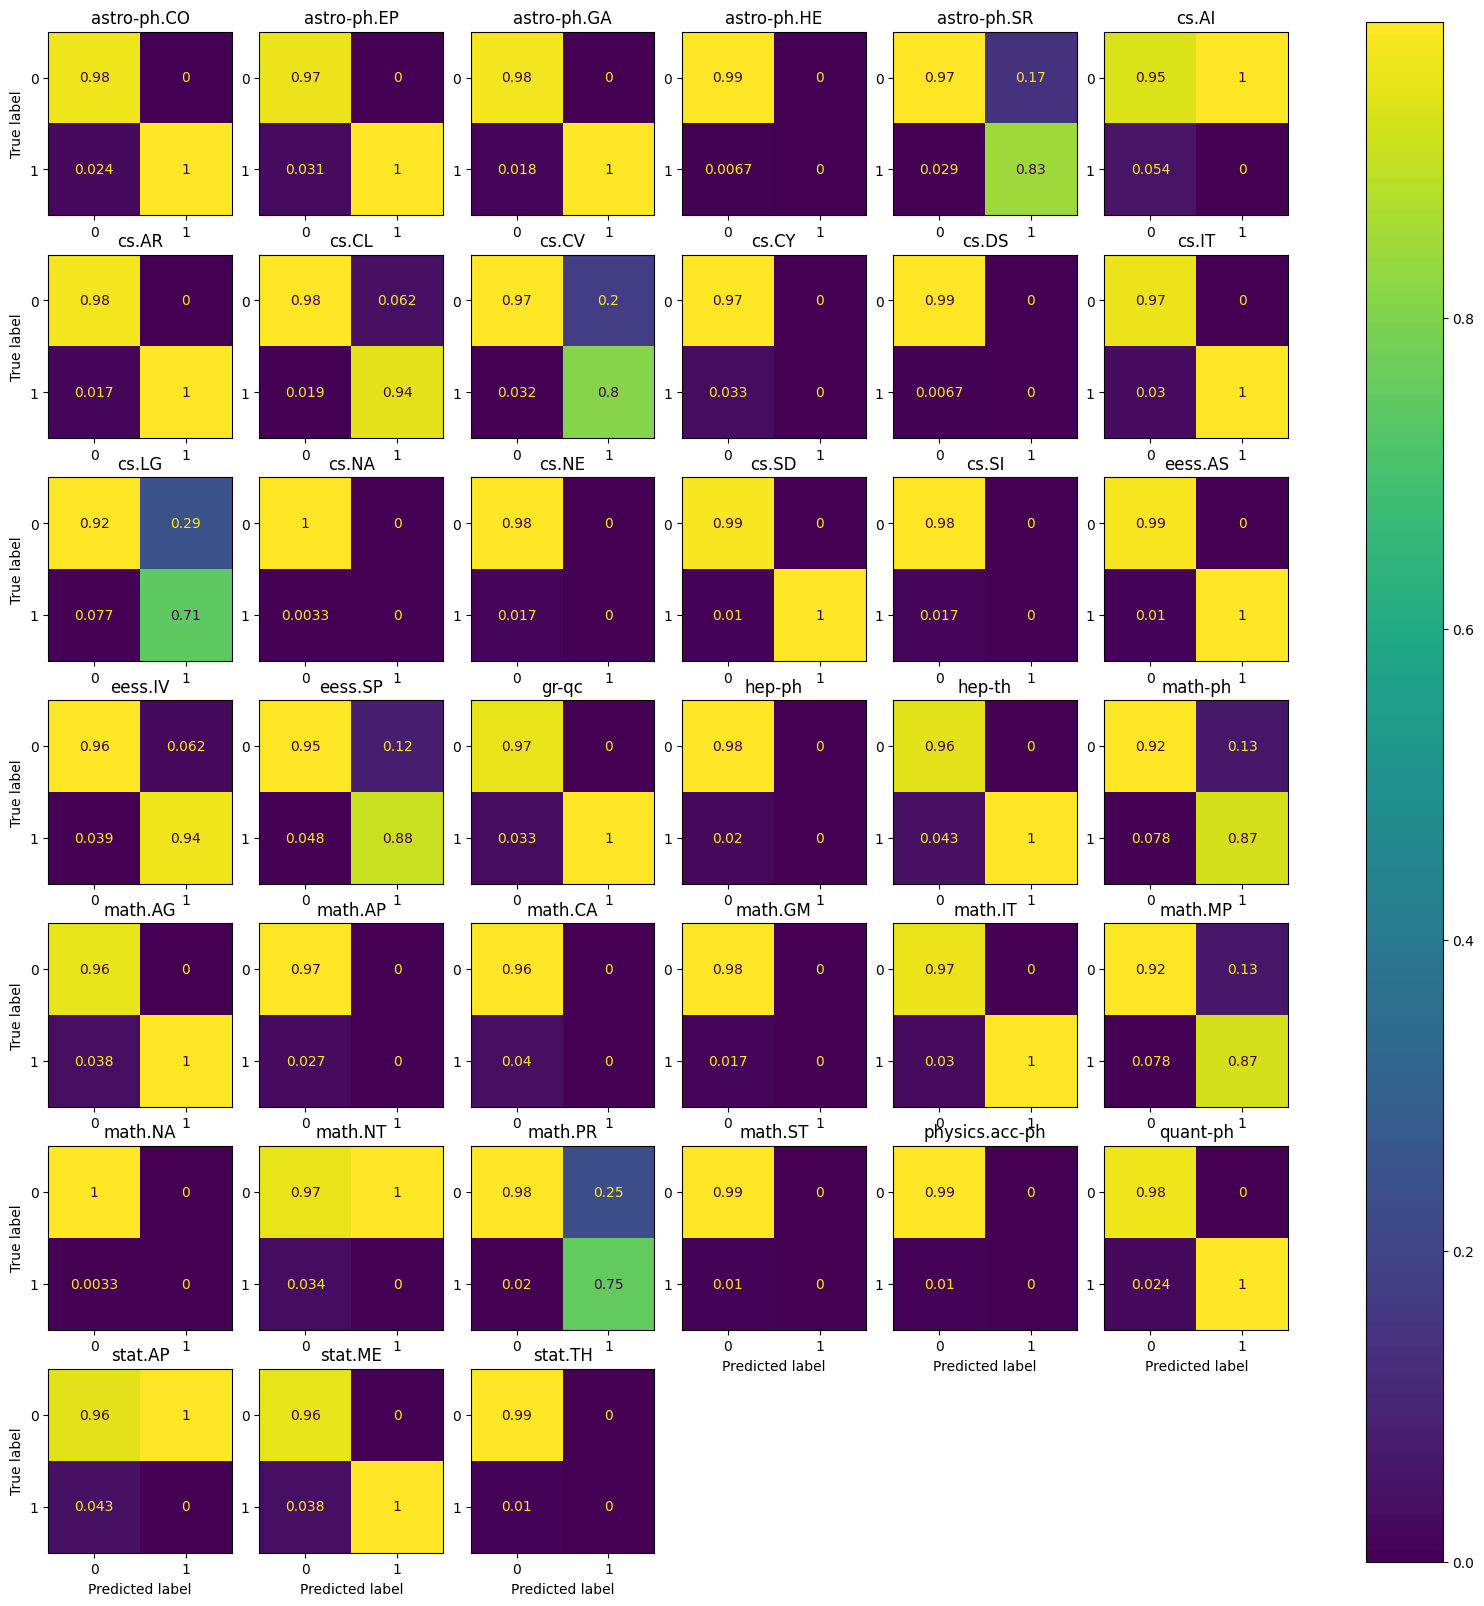

In [73]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [74]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('hep-th',)
--------------------
  true   : ('eess.IV',)
predicted: ()
--------------------
  true   : ('astro-ph.GA', 'astro-ph.SR')
predicted: ()
--------------------
  true   : ('cs.CL', 'cs.LG')
predicted: ('cs.CL',)
--------------------
  true   : ('hep-ph', 'hep-th')
predicted: ()
--------------------
  true   : ('stat.AP', 'stat.ME')
predicted: ()
--------------------
  true   : ('astro-ph.CO', 'astro-ph.GA')
predicted: ('astro-ph.GA',)
--------------------
  true   : ('cs.CL', 'cs.SD', 'eess.AS')
predicted: ('cs.CL', 'cs.SD', 'eess.AS')
--------------------
  true   : ('stat.AP', 'stat.ME')
predicted: ('stat.ME',)
--------------------
  true   : ('cs.SI',)
predicted: ()


Plot the ROC curve.

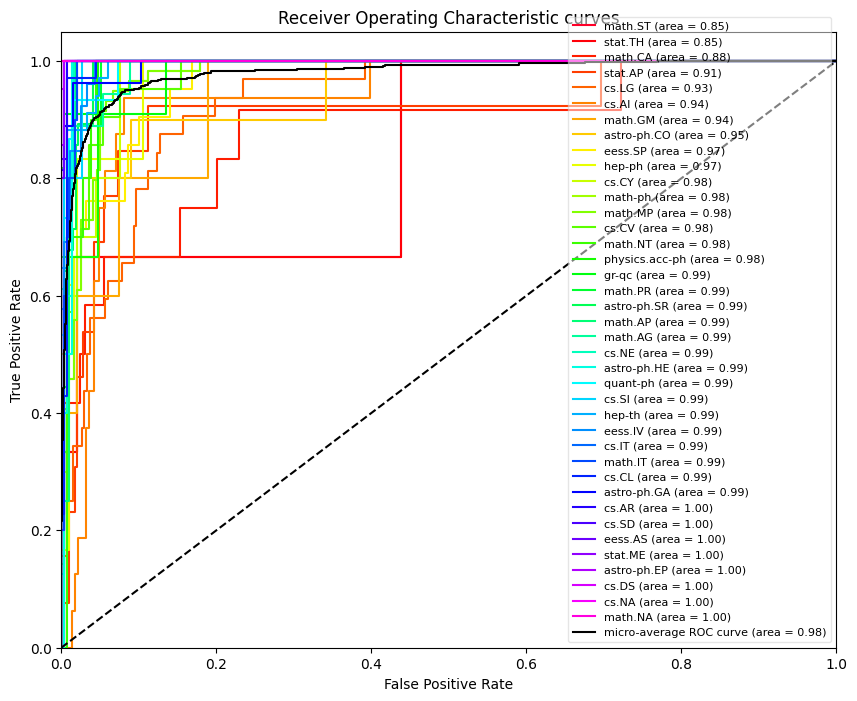

In [75]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

# 3) Keywords extraction

In [17]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.6 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/transformers/utils/gene

In [19]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Extract the keywords

In [50]:
df2 = df.copy(deep=False)

kw_model = KeyBERT('all-mpnet-base-v2')
extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                         kw_model=kw_model,
                                         seed=x["clean_title"].split(" "))
df2["keywords"] = df2.progress_apply(extraction, axis=1)
df2.head()

100%|██████████| 1000/1000 [01:39<00:00, 10.08it/s]


,id,title,category,abstract,clean_txt,clean_abstract,clean_title,text,clean_text,keywords
0,2306.11647,Safe and Scalable Real-Time Trajectory Plannin...,"[cs.RO, cs.SY, eess.SY]",This paper presents a real-time trajectory p...,safe scalable real time trajectory planning fr...,paper present real time trajectory planning fr...,safe scalable real time trajectory planning fr...,safe scalable real time trajectory planning fr...,safe scalable real time trajectory planning fr...,"[flight, reachability, decentralize, nmac]"
1,2209.15066,Global instability by runaway collisions in nu...,"[astro-ph.GA, astro-ph.CO]",The centres of galaxies host nuclear stellar...,global instability runaway collision nuclear s...,centre galaxy host nuclear stellar cluster sup...,global instability runaway collision nuclear s...,global instability runaway collision nuclear s...,global instability runaway collision nuclear s...,"[cluster, star, collision, nuclear]"
2,2401.17914,Attention Graph for Multi-Robot Social Navigat...,"[cs.RO, cs.AI]",Learning robot navigation strategies among p...,attention graph multi robot social navigation ...,learning robot navigation strategy pedestrian ...,attention graph multi robot social navigation ...,attention graph multi robot social navigation ...,attention graph multi robot social navigation ...,"[navigation, attention, human, graph]"
3,2401.17374,SHAMe-SF: Predicting the clustering of star-fo...,"[astro-ph.CO, astro-ph.GA]",With the advent of several galaxy surveys ta...,shame sf predict clustering star form galaxy e...,advent galaxy survey target star form galaxy i...,shame sf predict clustering star form galaxy e...,shame sf predict clustering star form galaxy e...,shame sf predict clustering star form galaxy e...,"[astrophysical, galaxy, cluster, correlation]"
4,2212.01485,A Theory of Semantic Communication,"[cs.IT, math.IT]",Semantic communication is an emerging resear...,theory semantic communication semantic communi...,semantic communication emerge research topic g...,theory semantic communication,theory semantic communication semantic communi...,theory semantic communication semantic communi...,"[semantic, communication, encoding, deep]"


In [51]:
df2.to_csv(f"./keywords.csv", index=False) # Save to csv

# 4) Classification X=kws, y=cat


In [52]:
path = "./keywords.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_txt,clean_abstract,clean_title,text,clean_text,keywords
995,2403.01686,AT2023lli: A Tidal Disruption Event with Promi...,"['astro-ph.HE', 'astro-ph.GA']","High-cadence, multiwavelength observations h...",tidal disruption event prominent optical early...,high cadence multiwavelength observation conti...,tidal disruption event prominent optical early...,tidal disruption event prominent optical early...,tidal disruption event prominent optical early...,"['accretion', 'telescope', 'uv', 'event']"
996,2307.11922,Selective Perception: Optimizing State Descrip...,"['cs.LG', 'cs.AI', 'cs.CL']",Large language models (LLMs) are being appli...,selective perception optimize state descriptio...,large language model llms apply actor sequenti...,selective perception optimize state descriptio...,selective perception optimize state descriptio...,selective perception optimize state descriptio...,"['robotic', 'learn', 'descriptions', 'state']"
997,2305.10164,Rational Dialogues,"['econ.GN', 'q-fin.EC']",Any finite conversation can be rationalized.\n,rational dialogue finite conversation rationalize,finite conversation rationalize,rational dialogue,rational dialogue finite conversation rationalize,rational dialogue finite conversation rationalize,"['conversation', 'rational', 'rationalize', 'f..."
998,2302.08861,AliasNet: Alias Artefact Suppression Network f...,"['eess.IV', 'cs.CV', 'cs.LG']",Sparse reconstruction is an important aspect...,aliasnet alias artefact suppression network ac...,sparse reconstruction important aspect mri hel...,aliasnet alias artefact suppression network ac...,aliasnet alias artefact suppression network ac...,aliasnet alias artefact suppression network ac...,"['mri', 'aliasnet', 'regularisation', 'phase']"
999,2403.06083,Ergodic properties of one-dimensional incommen...,"['math-ph', 'math.MP']",We review ergodic properties of one-dimensio...,ergodic property dimensional incommensurate bi...,review ergodic property dimensional incommensu...,ergodic property dimensional incommensurate bi...,ergodic property dimensional incommensurate bi...,ergodic property dimensional incommensurate bi...,"['ergodic', 'bilayer', 'dimension', 'limit']"


In [53]:
# Preparing X (features).
X = df["keywords"]


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [54]:
y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


accuracy = 0.21

                   precision    recall  f1-score   support

      astro-ph.CO       0.67      0.55      0.60        11
      astro-ph.GA       0.93      0.80      0.86        35
      astro-ph.HE       0.81      0.50      0.62        26
      astro-ph.SR       0.40      0.17      0.24        12
cond-mat.mes-hall       0.00      0.00      0.00         4
cond-mat.mtrl-sci       0.00      0.00      0.00         4
  cond-mat.str-el       0.62      0.48      0.54        21
cond-mat.supr-con       1.00      0.94      0.97        16
            cs.AI       0.67      0.43      0.53        72
            cs.CL       0.82      0.47      0.60        19
            cs.CV       0.59      0.38      0.46        34
            cs.HC       0.50      0.14      0.22         7
            cs.IR       1.00      1.00      1.00         2
            cs.IT       1.00      0.35      0.52        20
            cs.LG       0.47      0.27      0.34        56
            cs.NA       1.00      0.33

Plot confusion matrices.

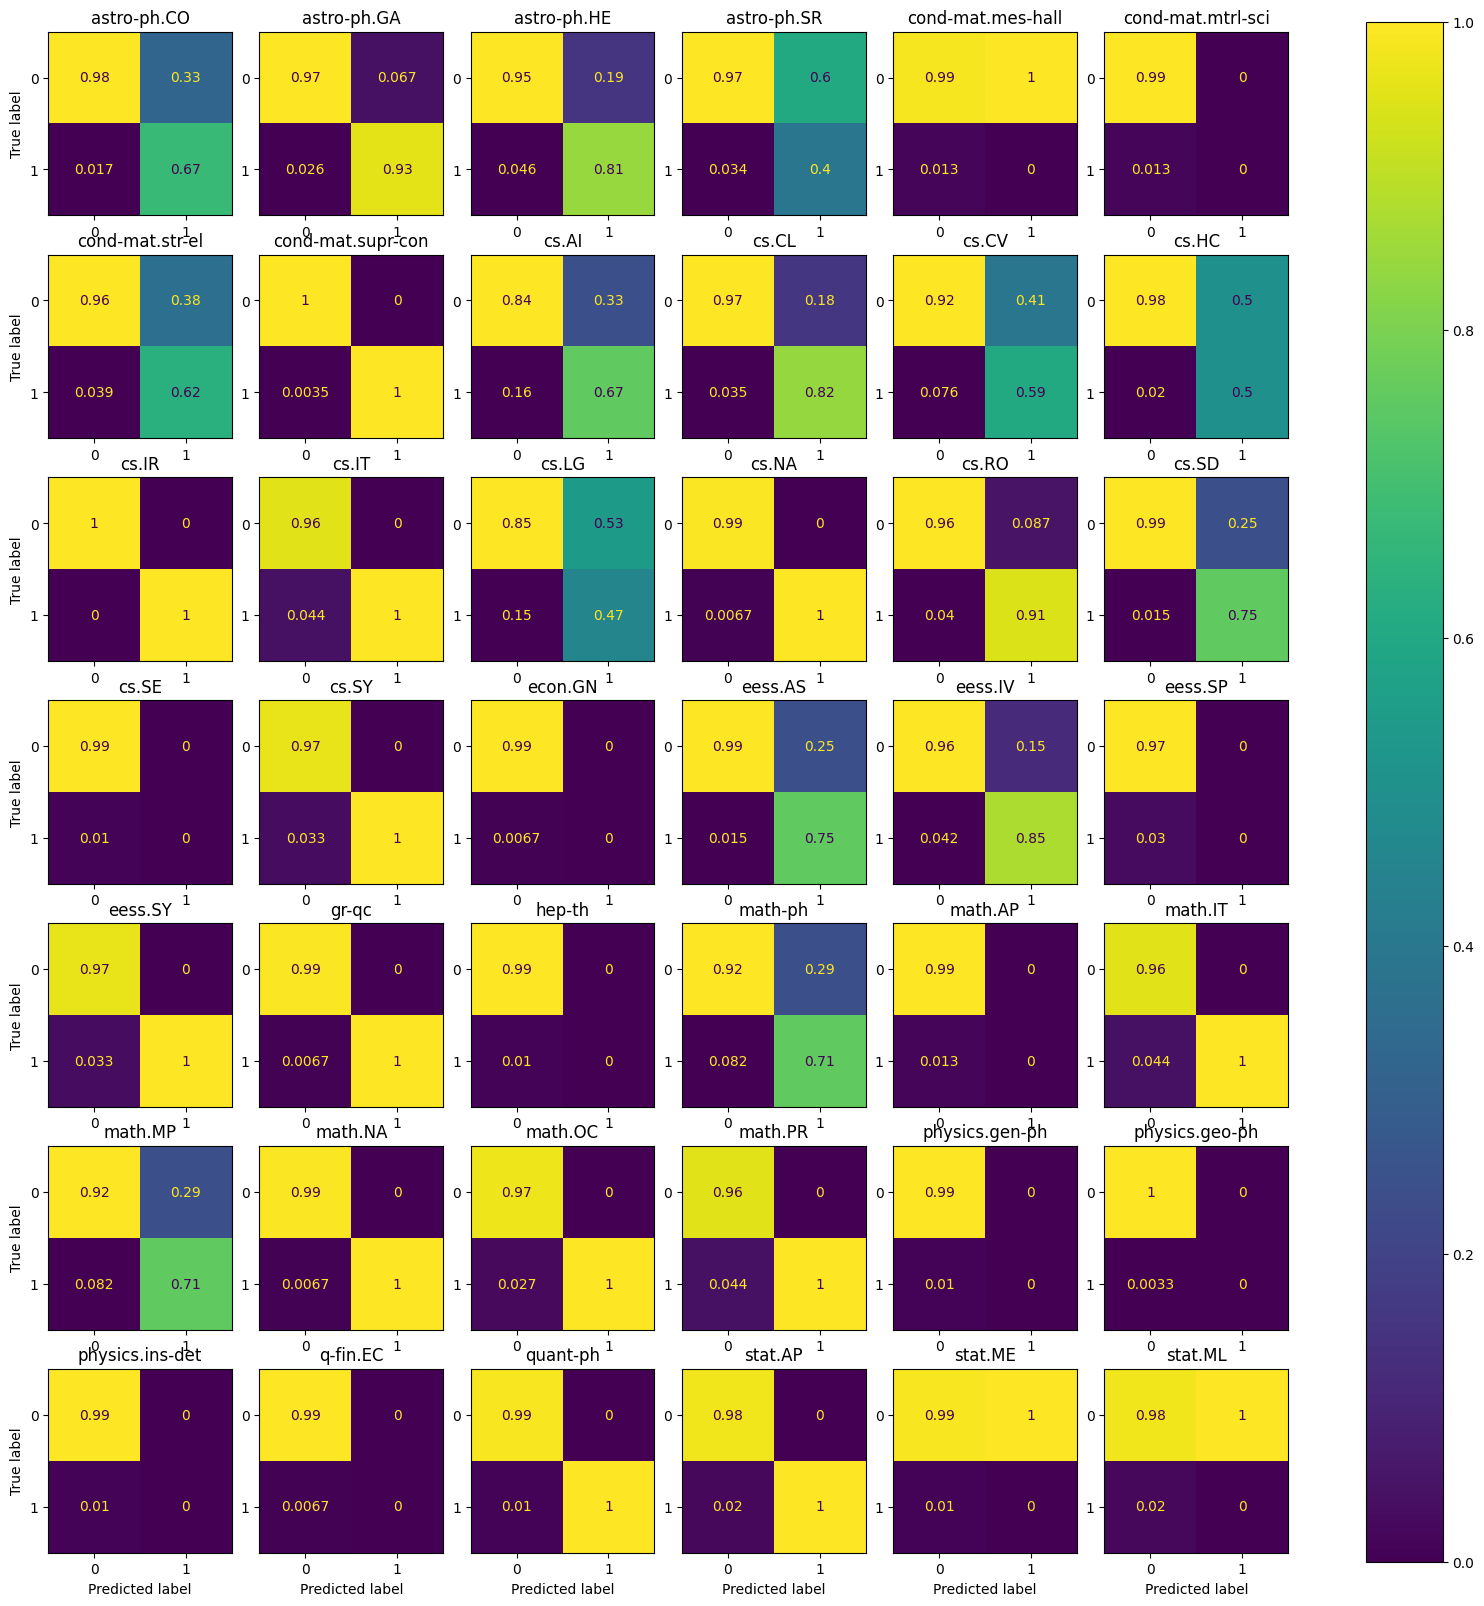

In [56]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [57]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('cs.SD', 'eess.AS')
predicted: ('cs.SD', 'eess.AS')
--------------------
  true   : ('cs.IT', 'math.IT')
predicted: ('cs.IT', 'math.IT')
--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ()
--------------------
  true   : ('cs.LG', 'math.OC')
predicted: ()
--------------------
  true   : ('cs.SD', 'eess.AS')
predicted: ('cs.SD', 'eess.AS')
--------------------
  true   : ('astro-ph.HE', 'astro-ph.SR')
predicted: ()
--------------------
  true   : ('math-ph', 'math.MP')
predicted: ('cond-mat.str-el',)
--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ('cs.AI', 'cs.RO')
--------------------
  true   : ('cs.LG', 'cs.SD', 'eess.AS')
predicted: ('cs.SD', 'eess.AS')
--------------------
  true   : ('cs.AI', 'cs.LG')
predicted: ()


Plot the ROC curve.

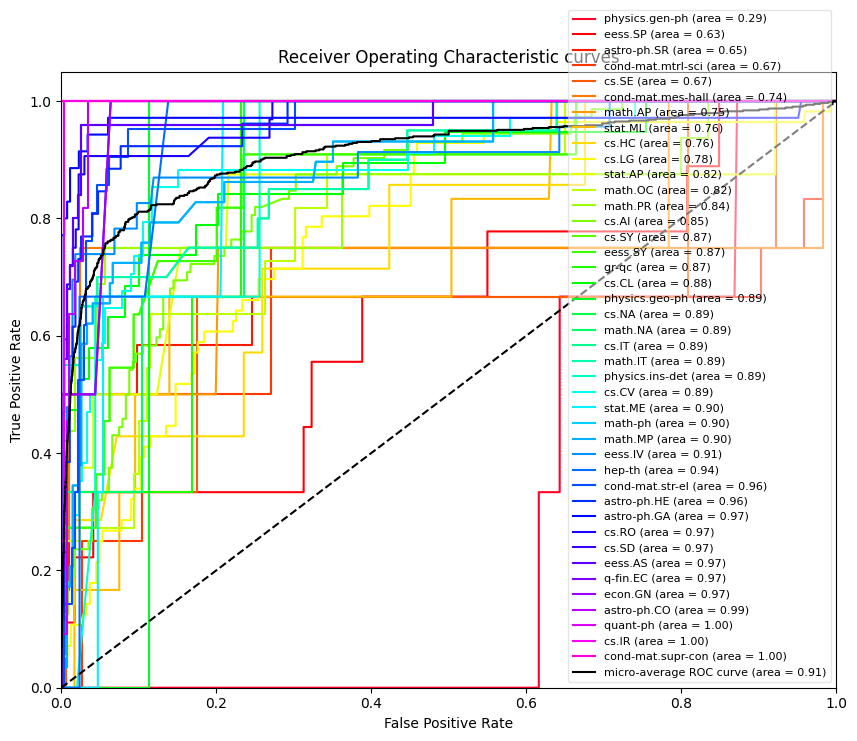

In [58]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)